In [2]:
import netCDF4 as nc
import rasterio
import xarray as xr


In [ ]:
nc = 'data/model_output_soil_moisture.nc'
nc_file = xr.open_dataset(nc)

In [9]:
import pandas as pd
import numpy as np

# Assuming nc_file is the loaded data
# You may need to adjust the keys based on the structure of your data

# Extracting necessary information
time = nc_file['time'].values
lat = nc_file['lat'].values
lon = nc_file['lon'].values
soil_moisture = nc_file['soil_moisture'].values.reshape(-1)

# Creating a DataFrame
df = pd.DataFrame({
    'time': np.repeat(time, len(lat) * len(lon)),
    'lat': np.tile(np.repeat(lat, len(lon)), len(time)),
    'lon': np.tile(np.tile(lon, len(lat)), len(time)),
    'soil_moisture': soil_moisture
})

# Displaying the DataFrame
print(df)


              time    lat    lon  soil_moisture
0       2000-01-01  55.25   4.75            NaN
1       2000-01-01  55.25   5.25            NaN
2       2000-01-01  55.25   5.75            NaN
3       2000-01-01  55.25   6.25            NaN
4       2000-01-01  55.25   6.75            NaN
...            ...    ...    ...            ...
4242739 2023-12-31  44.75  13.25            NaN
4242740 2023-12-31  44.75  13.75     425.416401
4242741 2023-12-31  44.75  14.25     427.023238
4242742 2023-12-31  44.75  14.75     422.696825
4242743 2023-12-31  44.75  15.25     419.654532

[4242744 rows x 4 columns]


In [ ]:
import pandas as pd

# Assuming df is your DataFrame

# Filter the data for years 2018 to 2021
df_filtered = df[df['time'].dt.year.between(2018, 2021) | (df['time'].dt.year == 2022)]

# Pivot the DataFrame
df_pivoted = df_filtered.pivot_table(index='time', columns=['lat', 'lon'], values='soil_moisture')

# Flatten the column names
df_pivoted.columns = ['grid{}'.format(i+1) for i in range(len(df_pivoted.columns))]

# Reset index to make 'time' a column again
df_pivoted.reset_index(inplace=True)

# Add latitude and longitude as columns
df_pivoted['latitude'] = df_filtered['lat'].iloc[0]
df_pivoted['longitude'] = df_filtered['lon'].iloc[0]

# Display the DataFrame
print(df_pivoted)


In [10]:
import pandas as pd

# Assuming df is your DataFrame

# Pivot the DataFrame
df_pivoted = df.pivot_table(index='time', columns=['lat', 'lon'], values='soil_moisture')

# Flatten the column names
df_pivoted.columns = ['grid{}'.format(i+1) for i in range(len(df_pivoted.columns))]

# Reset index to make 'time' a column again
df_pivoted.reset_index(inplace=True)

# Display the DataFrame
print(df_pivoted)


           time       grid1       grid2       grid3       grid4       grid5  \
0    2000-01-01  378.000000  378.000000  378.000000  378.000000  378.000000   
1    2000-01-02    0.000000    0.000000    0.000000    0.000000    0.000000   
2    2000-01-03    0.000000    0.000000    0.000000    0.000000    0.000000   
3    2000-01-04    0.000000    0.000000    0.000000    0.000000    0.000000   
4    2000-01-05    0.000000    0.000000    0.000000    0.000000    0.000000   
...         ...         ...         ...         ...         ...         ...   
8761 2023-12-27  419.770617  419.956189  420.507280  421.427265  421.410277   
8762 2023-12-28  419.837568  420.040798  420.640508  421.559028  421.417472   
8763 2023-12-29  419.815936  420.094009  420.758315  421.665200  421.442485   
8764 2023-12-30  419.748451  419.995003  420.685187  421.638169  421.417264   
8765 2023-12-31  419.732734  419.954719  420.676457  421.729578  421.476307   

           grid6       grid7       grid8       grid

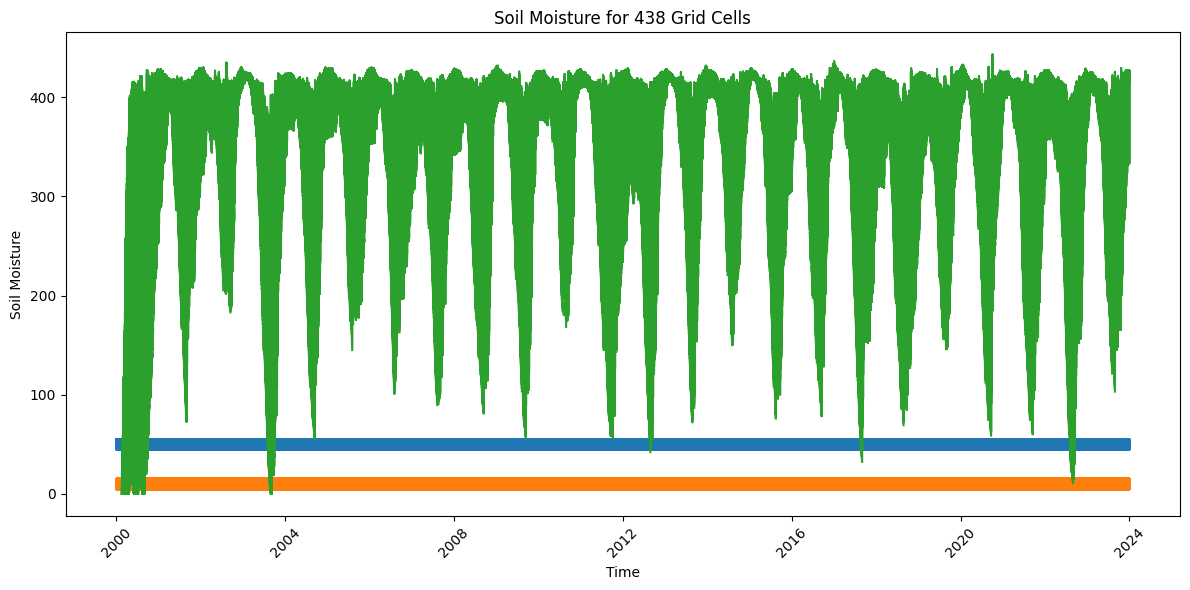

In [12]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with the pivoted data

# Plotting
plt.figure(figsize=(12, 6))
for col in df.columns[1:]:  # Exclude the 'time' column
    plt.plot(df['time'], df[col])

# Adding labels
plt.xlabel('Time')
plt.ylabel('Soil Moisture')
plt.title('Soil Moisture for 438 Grid Cells')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


In [15]:
for col in df_pivoted.columns:
    if col.startswith('grid'):
        grid_num = int(col[4:])  # Extract the grid number
        if grid_num <= 438:  # Check if the grid number is within the range
            df_pivoted[col+'_acc'] = 300 - df_pivoted[col]


/var/folders/ky/202vw8vj6yv23nntm6j0f2lc0000gn/T/ipykernel_4312/1965568814.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pivoted[col+'_acc'] = 300 - df_pivoted[col]
/var/folders/ky/202vw8vj6yv23nntm6j0f2lc0000gn/T/ipykernel_4312/1965568814.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pivoted[col+'_acc'] = 300 - df_pivoted[col]
/var/folders/ky/202vw8vj6yv23nntm6j0f2lc0000gn/T/ipykernel_4312/1965568814.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

In [23]:
# Create new columns to accumulate positive values for each grid cell
for col in df_pivoted.columns:
    if col.startswith('grid'):
        grid_name = col.split('_')[0]  # Extract the grid name without '_acc'
        df_pivoted[f'Accumulated Positive {grid_name}'] = 0

# Loop through each row to accumulate positive values and reduce when negative for each grid cell
for index, row in df_pivoted.iterrows():
    for col in df_pivoted.columns:
        if col.startswith('grid'):
            grid_name = col.split('_')[0]  # Extract the grid name without '_acc'
            accumulated_positive_col = f'Accumulated Positive {grid_name}'
            # Accumulate positive values for the grid cell
            if row[col] > 0:
                df_pivoted.at[index, accumulated_positive_col] += row[col]
            else:
                df_pivoted.at[index, accumulated_positive_col] = max(0, df_pivoted.at[index, accumulated_positive_col] + row[col])

# Display the first few rows of the DataFrame
print(df_pivoted.head())


/var/folders/ky/202vw8vj6yv23nntm6j0f2lc0000gn/T/ipykernel_4312/1904622266.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.75239765' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_pivoted.at[index, accumulated_positive_col] += row[col]
/var/folders/ky/202vw8vj6yv23nntm6j0f2lc0000gn/T/ipykernel_4312/1904622266.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10.46621846' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_pivoted.at[index, accumulated_positive_col] += row[col]
/var/folders/ky/202vw8vj6yv23nntm6j0f2lc0000gn/T/ipykernel_4312/1904622266.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.00548363' has dtype incompatible with int64, please explicitly cast to a comp

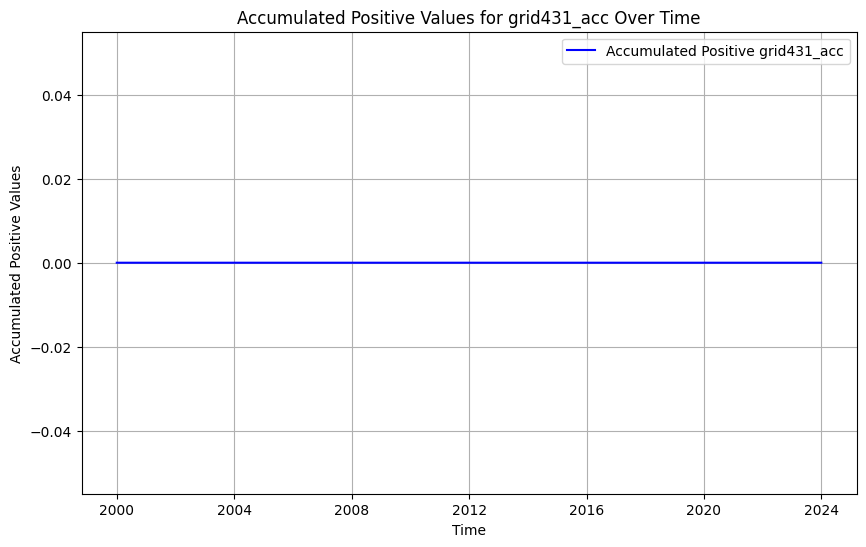

In [22]:
import matplotlib.pyplot as plt

# Plotting the accumulated positive values for grid431_acc
plt.figure(figsize=(10, 6))
plt.plot(df_pivoted['time'], df_pivoted['Accumulated Positive grid100_acc'], color='blue', label='Accumulated Positive grid431_acc')
plt.title('Accumulated Positive Values for grid431_acc Over Time')
plt.xlabel('Time')
plt.ylabel('Accumulated Positive Values')
plt.legend()
plt.grid(True)
plt.show()
